In [1]:
import pandas as pd
from datetime import datetime
import MetaTrader5 as mt5
import pytz
import sys
import pickle
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, max_error, median_absolute_error, r2_score, explained_variance_score

import seaborn as sns

from Long_Short_Term_Memory import Long_Short_Term_Memory
from Optimize_Portfolio import PortfolioManagement
import ta
from scipy.stats import zscore
import numpy as np
import scipy.stats as st

import os
import pandas as pd
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM
from tensorflow.keras import regularizers

In [2]:
gc_o_TIME_ZONE = pytz.timezone("Etc/UTC")
gc_dt_FROM = datetime(2013, 1, 1, tzinfo=gc_o_TIME_ZONE)
gc_dt_TO = datetime(2021, 10, 28, tzinfo=gc_o_TIME_ZONE)
gc_dt_SIMULATION_MODEL_FROM = "2021-09-01 00:00:00"


gc_a_SYMBOLS = []


gc_i_BACKWARD_TIME_WINDOW = -1
gc_i_FORWARD_TIME_WINDOW = 5


gc_dec_TRAINING_RATIO = 0.6
gc_dec_VALIDATION_RATIO = 0.2
gc_dec_TEST_RATIO = 0.2


gc_dec_MAX_RISK_RMSE = 0.10
gc_dec_INITIAL_BALANCE = 1000


g_aBackwardTimeSteps = range(gc_i_BACKWARD_TIME_WINDOW, 0)
g_aForwardTimeSteps = range(0, gc_i_FORWARD_TIME_WINDOW)

gc_i_PERIODS_OF_CLASSES = 5

g_aInputFeatures = set(['open', 'high', 'low', 'close', 'spread' ,'tick_volume'])
g_aOutputFeatures = pd.IntervalIndex.from_breaks(st.norm.ppf(np.linspace(0, 1, gc_i_PERIODS_OF_CLASSES+1)))

In [3]:
def ConvertSpreadValues(dfRates, aSymbolInfo):
    iDigits = aSymbolInfo.digits
    dfRates['spread'] = dfRates['spread'] * pow(10, -iDigits)

In [4]:
def dfShiftTimeSteps(dfRates, aTimeSteps):
    
    lstColumnNames = list([])
    for iTimeStep in aTimeSteps:
        for tplCol in dfRates.columns:
            lstColumnNames.append((iTimeStep, ) + tplCol)
    
    
    lstIndexNames = ("Time Step",) +  tuple(dfRates.columns.names)
    
    dicColumnIndices = pd.MultiIndex.from_tuples(
        lstColumnNames,
        names = lstIndexNames
        )


    dfShiftedRates = pd.DataFrame(
        columns=dicColumnIndices, 
        index=dfRates.index)
    
    

    for i in aTimeSteps:
        dfShiftedRates[i] = dfRates.shift(-i)

    dfShiftedRates.dropna(inplace=True)

    return dfShiftedRates

In [5]:
def dfGetMarketData(sSymbol):

    if not mt5.initialize():
        print("initialize() failed, error code =", mt5.last_error())
        sys.exit()

    aSymbolInfo = mt5.symbol_info(sSymbol)
    if not aSymbolInfo:
        print("symbol_info() failed, error code =", mt5.last_error())
        sys.exit()

    aRates = mt5.copy_rates_range(
        sSymbol, mt5.TIMEFRAME_H1, gc_dt_FROM, gc_dt_TO)
    if len(aRates) == 0:
        print("copy_rates_range() failed, error code =", mt5.last_error())
        sys.exit()

    mt5.shutdown()

    dfRates = pd.DataFrame(aRates)

    dfRates['time'] = pd.to_datetime(dfRates['time'], unit='s')
    dfRates.set_index('time', inplace=True)
    dfRates.drop('real_volume', axis=1, inplace=True)

    ConvertSpreadValues(dfRates, aSymbolInfo)
    AddSeasonalFeatures(dfRates)
    AddReturns(dfRates)
    dfRates = dfAddTechnicalIndicators(dfRates)

    dfRates.columns  = pd.MultiIndex.from_product(
        [[sSymbol], dfRates.columns], 
        names=["Time Series", "Feature"])
    
    
    return dfRates

In [6]:
def dfAddTechnicalIndicators(dfRates):
    global g_aInputFeatures 
    
    
    iTimeWindow = 24
    
    dfHigh = dfRates["high"]
    dfLow = dfRates["low"]
    dfClose = dfRates["close"]
    
    # Average Dricetional Movement Index
    oAdx = ta.trend.ADXIndicator(dfHigh, dfLow, dfClose, iTimeWindow, False)
    
    dfAdx = oAdx.adx()
    dfAdx.drop(dfAdx[dfAdx == 0].index, inplace = True)
    g_aInputFeatures.add(dfAdx.name)
    
    dfAdxNeg = oAdx.adx_neg()
    dfAdxNeg.drop(dfAdxNeg[dfAdxNeg == 0].index, inplace = True)
    g_aInputFeatures.add(dfAdxNeg.name)
    
    
    dfAdxPos = oAdx.adx_pos()
    dfAdxPos.drop(dfAdxPos[dfAdxPos == 0].index, inplace = True)
    g_aInputFeatures.add(dfAdxPos.name)
    
    
    dfRates = dfRates.join(dfAdx, how = "inner")
    dfRates = dfRates.join(dfAdxNeg, how = "inner")
    dfRates = dfRates.join(dfAdxPos, how = "inner")

    
    # Aroon Indicator
    oAroon = ta.trend.AroonIndicator(dfClose, iTimeWindow, False)
    dfAroonDown = oAroon.aroon_down()
    dfAroonDown.dropna(inplace = True)
    g_aInputFeatures.add(dfAroonDown.name)
    
    dfAroonIndicator = oAroon.aroon_indicator() 
    dfAroonIndicator.dropna(inplace = True)
    g_aInputFeatures.add(dfAroonIndicator.name)

    
    dfAroonUp = oAroon.aroon_up()
    dfAroonUp.dropna(inplace = True)
    g_aInputFeatures.add(dfAroonUp.name)
    
    dfRates = dfRates.join(dfAroonDown, how = "inner")
    dfRates = dfRates.join(dfAroonIndicator, how = "inner")
    dfRates = dfRates.join(dfAroonUp, how = "inner")
    
    
    # Commodity Channel Index
    oCci = ta.trend.CCIIndicator(dfHigh, dfLow,dfClose, iTimeWindow)
    dfCci = oCci.cci()
    dfCci.dropna(inplace = True)
    g_aInputFeatures.add(dfCci.name)
    
    dfRates = dfRates.join(dfCci, how = "inner")
    
    
    # Detrended Price Oscillator (DPO)
    oDpo = ta.trend.DPOIndicator(dfClose, iTimeWindow)
    dfDpo = oDpo.dpo()
    dfDpo.dropna(inplace = True)
    g_aInputFeatures.add(dfDpo.name)    
    
    dfRates = dfRates.join(dfDpo, how = "inner")
    
    
    # EMA - Exponential Moving Average
    oEma = ta.trend.EMAIndicator(dfClose, iTimeWindow)
    dfEma = oEma.ema_indicator()
    dfEma.dropna(inplace = True)
    g_aInputFeatures.add(dfEma.name)
    
    dfRates = dfRates.join(dfEma, how = "inner")
    
    
    return dfRates

In [7]:
def AddSeasonalFeatures(dfRates):
    global g_aInputFeatures 
    
    c_a_SEASONAL_FEATURES = ["year", "month", "day", "dayofweek", "hour"]
    for sSeasonalFeature in c_a_SEASONAL_FEATURES:
        exec("dfRates[sSeasonalFeature] = dfRates.index." + sSeasonalFeature)
        g_aInputFeatures.add(sSeasonalFeature)

In [8]:
def AddReturns(dfRates):
    dfRates["return"] = (dfRates["open"] - dfRates["close"])/dfRates["open"]

In [9]:
def dfOversampleImbalancedData(dfX, dfY):
    
#     oOversample = SMOTE()
#     aX, aY = oOversample.fit_resample(dfX.values, dfY.values)
    
#     dfX = pd.DataFrame(data = aX, columns = dfX.columns)
#     dfY = pd.DataFrame(data = aY, columns = dfY.columns)
    
    dfXCopy = dfX.copy()
    dfYCopy = dfY.copy()
        
    dfCombinations = dfYCopy.astype(str).agg('-'.join, axis=1)
    dfCombinationsStats = dfCombinations.value_counts()
    dfCombinationsStats = pd.DataFrame(dfCombinationsStats).reset_index()
    
    
    iMaxAmount = dfCombinationsStats.iloc[0,1]
    for i in range(1, len(dfCombinationsStats) ):
        
        sCombination = dfCombinationsStats.iloc[i, 0]
        iSamplesNeeded = iMaxAmount - dfCombinationsStats.iloc[i, 1]
        
        dfSampledIndex =  dfCombinations[dfCombinations == sCombination].sample(iSamplesNeeded, replace = True).index
        
        dfSampledX = dfXCopy.loc[dfSampledIndex]
        dfSampledY = dfYCopy.loc[dfSampledIndex]
        
    
        dfX = dfX.append(dfSampledX , ignore_index= True)
        dfY = dfY.append(dfSampledY , ignore_index= True)
        
    
    dfX,dfY = shuffle(dfX,dfY )
    

    return dfX, dfY

In [10]:
def dfSplitData(dfInput, dfOutput):
    dfInputTrainValidation, dfInputTest, dfOutputTrainValidation, dfOutputTest = train_test_split(
        dfInput,
        dfOutput,
        test_size=gc_dec_TEST_RATIO,
        shuffle=False)

    dfInputTrain, dfInputValidation, dfOutputTrain, dfOutputValidation = train_test_split(
        dfInputTrainValidation,
        dfOutputTrainValidation,
        test_size=(1/(1 -gc_dec_TEST_RATIO))-1,
        shuffle=False)
    
    
    dfInputTrain = dfInputTrain.astype(float)
    dfInputValidation = dfInputValidation.astype(float)
    dfInputTest = dfInputTest.astype(float)
    dfOutputTrain = dfOutputTrain.astype(float)
    dfOutputValidation = dfOutputValidation.astype(float)
    dfOutputTest = dfOutputTest.astype(float)
    
    return dfInputTrain, dfInputValidation, dfInputTest, dfOutputTrain, dfOutputValidation, dfOutputTest

In [180]:
def dfScaleData(sScalerName,dfTrain,dfValidation, dfTest):
    sScalersDirectory = os.path.join(sSubModelName , "__scalers__")

    oScaler = MinMaxScaler()

    oScaler.fit(dfTrain)

    aScaledTrain = oScaler.transform(dfTrain)
    aScaledValidation = oScaler.transform(dfValidation)
    aScaledTest = oScaler.transform(dfTest)

    dfScaledTrain = pd.DataFrame(aScaledTrain, columns = dfTrain.columns, index = dfTrain.index)
    dfScaledValidation = pd.DataFrame(aScaledValidation, columns = dfValidation.columns, index = dfValidation.index)
    dfScaledTest = pd.DataFrame(aScaledTest, columns = dfTest.columns, index = dfTest.index)

    sScalerFilePath =os.path.join(sScalersDirectory, sScalerName + ".sav")
    os.makedirs(os.path.dirname(sScalerFilePath), exist_ok=True)
    pickle.dump(oScaler, open(sScalerFilePath, 'wb'))
    
    
    return dfScaledTrain, dfScaledValidation, dfScaledTest

In [12]:
sSymbol = "USDCAD"
aRelevantSymbols = []

In [13]:
dfRates = dfGetMarketData(sSymbol)

for sRelevantSymbol in aRelevantSymbols:
    dfRelevantRates = dfGetMarketData(sRelevantSymbol)
    dfRates = dfRates.join(dfRelevantRates, how = "inner")

C:\Users\yunus\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\ta\trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
C:\Users\yunus\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\ta\trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


In [14]:
dfRates

Time Series           USDCAD                                                  \
Feature                 open     high      low    close tick_volume   spread   
time                                                                           
2013-01-04 07:00:00  0.98842  0.98848  0.98813  0.98830         501  0.00029   
2013-01-04 08:00:00  0.98829  0.98882  0.98814  0.98881         570  0.00029   
2013-01-04 09:00:00  0.98882  0.99068  0.98879  0.99059        1015  0.00029   
2013-01-04 10:00:00  0.99055  0.99082  0.99001  0.99033        1203  0.00029   
2013-01-04 11:00:00  0.99032  0.99074  0.98985  0.99031        1021  0.00025   
...                      ...      ...      ...      ...         ...      ...   
2021-10-27 20:00:00  1.23292  1.23412  1.23159  1.23319       31996  0.00018   
2021-10-27 21:00:00  1.23321  1.23472  1.23318  1.23435       28110  0.00018   
2021-10-27 22:00:00  1.23435  1.23644  1.23435  1.23636       40121  0.00018   
2021-10-27 23:00:00  1.23636  1.23637  1.23483  1.23485       10631  0.00018   
2021-10-28 00:00:00  1.23478  1.23632  1.23475  1.23613        2151  0.00020   

Time Series                                    ...                       \
Feature              year month day dayofweek  ...    return        adx   
time                                           ...                        
2013-01-04 07:00:00  2013     1   4         4  ...  0.000121  14.779169   
2013-01-04 08:00:00  2013     1   4         4  ... -0.000526  14.758243   
2013-01-04 09:00:00  2013     1   4         4  ... -0.001790  15.318441   
2013-01-04 10:00:00  2013     1   4         4  ...  0.000222  15.892986   
2013-01-04 11:00:00  2013     1   4         4  ...  0.000010  16.363965   
...                   ...   ...  ..       ...  ...       ...        ...   
2021-10-27 20:00:00  2021    10  27         2  ... -0.000219  20.547753   
2021-10-27 21:00:00  2021    10  27         2  ... -0.000924  20.838039   
2021-10-27 22:00:00  2021    10  27         2  ... -0.001628  20.677858   
2021-10-27 23:00:00  2021    10  27         2  ...  0.001221  20.524351   
2021-10-28 00:00:00  2021    10  28         3  ... -0.001093  20.391632   

Time Series                                                           \
Feature                adx_neg    adx_pos aroon_down_24 aroon_ind_24   
time                                                                   
2013-01-04 07:00:00  18.588235  23.306295     33.333333    54.166667   
2013-01-04 08:00:00  18.056092  24.070481     29.166667    54.166667   
2013-01-04 09:00:00  16.671855  29.769788     25.000000    75.000000   
2013-01-04 10:00:00  16.119222  29.355911     20.833333    75.000000   
2013-01-04 11:00:00  16.187261  28.281086     16.666667    75.000000   
...                        ...        ...           ...          ...   
2021-10-27 20:00:00  30.290329  15.790205     95.833333   -16.666667   
2021-10-27 21:00:00  29.219196  16.609577     91.666667   -16.666667   
2021-10-27 22:00:00  27.825734  19.742189     87.500000   -16.666667   
2021-10-27 23:00:00  26.841515  19.043892     83.333333   -16.666667   
2021-10-28 00:00:00  26.052937  18.353300     79.166667   -16.666667   

Time Series                                                      
Feature             aroon_up_24         cci    dpo_24    ema_24  
time                                                             
2013-01-04 07:00:00   87.500000   77.760923 -0.001457  0.987280  
2013-01-04 08:00:00   83.333333   83.006430 -0.001221  0.987402  
2013-01-04 09:00:00  100.000000  134.326875 -0.001695  0.987657  
2013-01-04 10:00:00   95.833333  137.194411 -0.000205  0.987871  
2013-01-04 11:00:00   91.666667  124.278645  0.000323  0.988066  
...                         ...         ...       ...       ...  
2021-10-27 20:00:00   79.166667 -223.408502 -0.000045  1.237943  
2021-10-27 21:00:00   75.000000 -150.144117  0.000275  1.237655  
2021-10-27 22:00:00   70.833333  -83.694158  0.000058  1.237552  
2021-10-27 23:00:00   66.66

In [15]:
dfInput  = dfRates.loc[:, dfRates.columns.get_level_values(1).isin(g_aInputFeatures)]
dfInput = dfShiftTimeSteps(dfInput, g_aBackwardTimeSteps)

In [16]:
dfInput

Time Step                 -1                                                  \
Time Series           USDCAD                                                   
Feature                 open     high      low    close tick_volume   spread   
time                                                                           
2013-01-04 08:00:00  0.98842  0.98848  0.98813  0.98830       501.0  0.00029   
2013-01-04 09:00:00  0.98829  0.98882  0.98814  0.98881       570.0  0.00029   
2013-01-04 10:00:00  0.98882  0.99068  0.98879  0.99059      1015.0  0.00029   
2013-01-04 11:00:00  0.99055  0.99082  0.99001  0.99033      1203.0  0.00029   
2013-01-04 12:00:00  0.99032  0.99074  0.98985  0.99031      1021.0  0.00025   
...                      ...      ...      ...      ...         ...      ...   
2021-10-27 20:00:00  1.23372  1.23425  1.23206  1.23292     39555.0  0.00018   
2021-10-27 21:00:00  1.23292  1.23412  1.23159  1.23319     31996.0  0.00018   
2021-10-27 22:00:00  1.23321  1.23472  1.23318  1.23435     28110.0  0.00018   
2021-10-27 23:00:00  1.23435  1.23644  1.23435  1.23636     40121.0  0.00018   
2021-10-28 00:00:00  1.23636  1.23637  1.23483  1.23485     10631.0  0.00018   

Time Step                                                                      \
Time Series                                                                     
Feature                year month   day dayofweek  hour        adx    adx_neg   
time                                                                            
2013-01-04 08:00:00  2013.0   1.0   4.0       4.0   7.0  14.779169  18.588235   
2013-01-04 09:00:00  2013.0   1.0   4.0       4.0   8.0  14.758243  18.056092   
2013-01-04 10:00:00  2013.0   1.0   4.0       4.0   9.0  15.318441  16.671855   
2013-01-04 11:00:00  2013.0   1.0   4.0       4.0  10.0  15.892986  16.119222   
2013-01-04 12:00:00  2013.0   1.0   4.0       4.0  11.0  16.363965  16.187261   
...                     ...   ...   ...       ...   ...        ...        ...   
2021-10-27 20:00:00  2021.0  10.0  27.0       2.0  19.0  20.073006  31.007771   
2021-10-27 21:00:00  2021.0  10.0  27.0       2.0  20.0  20.547753  30.290329   
2021-10-27 22:00:00  2021.0  10.0  27.0       2.0  21.0  20.838039  29.219196   
2021-10-27 23:00:00  2021.0  10.0  27.0       2.0  22.0  20.677858  27.825734   
2021-10-28 00:00:00  2021.0  10.0  27.0       2.0  23.0  20.524351  26.841515   

Time Step                                                              \
Time Series                                                             
Feature                adx_pos aroon_down_24 aroon_ind_24 aroon_up_24   
time                                                                    
2013-01-04 08:00:00  23.306295     33.333333    54.166667   87.500000   
2013-01-04 09:00:00  24.070481     29.166667    54.166667   83.333333   
2013-01-04 10:00:00  29.769788     25.000000    75.000000  100.000000   
2013-01-04 11:00:00  29.355911     20.833333    75.000000   95.833333   
2013-01-04 12:00:00  28.281086     16.666667    75.000000   91.666667   
...                        ...           ...          ...         ...   
2021-10-27 20:00:00  16.757362    100.000000   -16.666667   83.333333   
2021-10-27 21:00:00  15.790205     95.833333   -16.666667   79.166667   
2021-10-27 22:00:00  16.609577     91.666667   -16.666667   75.000000   
2021-10-27 23:00:00  19.742189     87.500000   -16.666667   70.833333   
2021-10-28 00:00:00  19.043892     83.333333   -16.666667   66.666667   

Time Step                                            
Time Series                                          
Feature                     cci    dpo_24    ema_24  
time                                                 
2013-01-04 08:00:00   77.760923 -0.001457  0.987280  
2013-01-04 09:00:00   83.006430 -0.001221  0.987402  
2013-01-04 10:00:00  134.326875 -0.001695  0.987657  
2013-01-04 11:00:00  137.194411 -0.000205  0.987871  
2013-01-04 12:00:00  124.278645  0.000323  0.988066  
.

In [17]:
i = 1
j = 3

In [18]:
aColumns = pd.MultiIndex.from_tuples(
    [(i,j)],
    names = ["From","To"])

In [19]:
dfOutput = pd.DataFrame(index = dfInput.index, 
                        columns = aColumns)

    
dfSpread = dfRates[sSymbol]["spread"]
dfOpen = dfRates[sSymbol]["open"].shift(-i)
dfClose = dfRates[sSymbol]["close"].shift(-j)

dfNetReturn = (abs(dfClose - dfOpen) - dfSpread)
dfReturn = (dfClose - dfOpen)/dfOpen

# INVESTABILITY MODEL

In [20]:
sModelName = os.path.join(sSymbol , "__investability model__")

In [21]:
sSubModelName = os.path.join(sModelName , "__"+ str(i) +"  " + str(j) + "__")

## Preprocessing

In [22]:
dfInputInvestability = dfInput.copy()
dfOutputInvestability = dfOutput.copy()

In [23]:
dfMaskNonInvestable = dfNetReturn<=0
dfMaskInvestable = dfNetReturn>0

dfOutputInvestability.loc[dfMaskNonInvestable] = 0
dfOutputInvestability.loc[dfMaskInvestable] = 1

In [24]:
dfOutputInvestability

From,1
To,3
time,
2013-01-04 08:00:00,1
2013-01-04 09:00:00,1
2013-01-04 10:00:00,1
2013-01-04 11:00:00,1
2013-01-04 12:00:00,1
...,...
2021-10-27 20:00:00,1
2021-10-27 21:00:00,1


### Remove Empty Rows

In [25]:
aMissingOutputs = dfOutputInvestability[dfOutputInvestability.isna().any(axis=1)].index
dfInputInvestability.drop(aMissingOutputs, inplace = True)
dfOutputInvestability.drop(aMissingOutputs, inplace = True)

### Split Data

In [26]:
dfInputTrain, dfInputValidation, dfInputTest, dfOutputTrain, dfOutputValidation, dfOutputTest = dfSplitData(dfInputInvestability, 
                                                                                                            dfOutputInvestability)

### Scale Data

In [27]:
dfScaledInputTrain, dfScaledInputValidation, dfScaledInputTest = dfScaleData("input", dfInputTrain,dfInputValidation, dfInputTest )

### Balance Classes

In [28]:
dfOutputTrain.value_counts()

(1, 3)
1.0       28802
0.0        4030
dtype: int64

In [29]:
dfBalancedInputTrain , dfBalancedOutputTrain = dfOversampleImbalancedData(
    dfScaledInputTrain,
    dfOutputTrain)
dfBalancedOutputTrain.columns = aColumns

In [30]:
dfBalancedOutputTrain.value_counts()

(1, 3)
0.0       28802
1.0       28802
dtype: int64

In [31]:
dfOutputValidation.value_counts()

(1, 3)
1.0       9587
0.0       1357
dtype: int64

In [32]:
dfOutputTest.value_counts()

(1, 3)
1.0       9898
0.0       1047
dtype: int64

## Train

Epoch 1/10000
113/113 [==============================] - 10s 14ms/step - loss: 0.6816 - val_loss: 0.6230
Epoch 2/10000
113/113 [==============================] - 1s 10ms/step - loss: 0.6722 - val_loss: 0.5756
Epoch 3/10000
113/113 [==============================] - 1s 10ms/step - loss: 0.6669 - val_loss: 0.5427
Epoch 4/10000
113/113 [==============================] - 1s 10ms/step - loss: 0.6643 - val_loss: 0.5228
Epoch 5/10000
113/113 [==============================] - 1s 11ms/step - loss: 0.6630 - val_loss: 0.5117
Epoch 6/10000
113/113 [==============================] - 1s 10ms/step - loss: 0.6622 - val_loss: 0.5069
Epoch 7/10000
113/113 [==============================] - 2s 14ms/step - loss: 0.6617 - val_loss: 0.5056
Epoch 8/10000
113/113 [==============================] - 1s 12ms/step - loss: 0.6612 - val_loss: 0.5060
Epoch 9/10000
113/113 [==============================] - 1s 10ms/step - loss: 0.6607 - val_loss: 0.5068
Epoch 10/10000
113/113 [==============================] - 1s 10

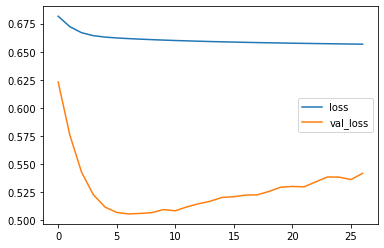

In [33]:
oPredictiveModel = Long_Short_Term_Memory(
    sSubModelName, 
    dfScaledInputTrain.shape[1], 
    1,
    len(g_aBackwardTimeSteps), 
    1
    )

oPredictiveModel.Train(dfBalancedInputTrain, 
                       dfBalancedOutputTrain,
                       dfScaledInputValidation,
                       dfOutputValidation
                      )

## Test

In [34]:
aPredictionProb, _ = oPredictiveModel.aPredict(dfScaledInputTest)

aPrediction = aPredictionProb.round()

dfPrediction = pd.DataFrame(aPrediction, index = dfInputTest.index)
dfPrediction.columns = aColumns

In [35]:
dfPrediction.value_counts()

(1, 3)
1.0       7856
0.0       3089
dtype: int64

In [36]:
print(classification_report(dfOutputTest, dfPrediction))

              precision    recall  f1-score   support

         0.0       0.12      0.34      0.17      1047
         1.0       0.91      0.72      0.81      9898

    accuracy                           0.69     10945
   macro avg       0.51      0.53      0.49     10945
weighted avg       0.84      0.69      0.75     10945



# DIRECTIONAL MODEL

In [37]:
sModelName = os.path.join(sSymbol , "__directional model__")

In [38]:
sSubModelName = os.path.join(sModelName , "__"+ str(i) +"  " + str(j) + "__")

## Preprocessing

In [39]:
dfInputDirectional = dfInput.copy()
dfOutputDirectional = dfOutput.copy()

In [40]:
dfMaskUpward = dfClose>dfOpen
dfMaskDownward = dfClose<dfOpen 

dfOutputDirectional.loc[(dfMaskInvestable) & (dfMaskDownward)] = 0
dfOutputDirectional.loc[(dfMaskInvestable) & (dfMaskUpward)] = 1

In [41]:
dfOutputDirectional

From,1
To,3
time,
2013-01-04 08:00:00,1
2013-01-04 09:00:00,1
2013-01-04 10:00:00,1
2013-01-04 11:00:00,1
2013-01-04 12:00:00,0
...,...
2021-10-27 20:00:00,1
2021-10-27 21:00:00,1


### Remove Empty Rows

In [42]:
aMissingOutputs = dfOutputDirectional[dfOutputDirectional.isna().any(axis=1)].index
dfInputDirectional.drop(aMissingOutputs, inplace = True)
dfOutputDirectional.drop(aMissingOutputs, inplace = True)

### Split Data

In [43]:
dfInputTrain, dfInputValidation, dfInputTest, dfOutputTrain, dfOutputValidation, dfOutputTest = dfSplitData(dfInputDirectional, 
                                                                                                            dfOutputDirectional)

### Scale Data

In [44]:
dfScaledInputTrain, dfScaledInputValidation, dfScaledInputTest = dfScaleData("input", dfInputTrain,dfInputValidation, dfInputTest)

### Balance Classes

In [45]:
dfOutputTrain.value_counts()

(1, 3)
1.0       14742
0.0       14229
dtype: int64

In [46]:
dfBalancedInputTrain , dfBalancedOutputTrain = dfOversampleImbalancedData(
    dfScaledInputTrain,
    dfOutputTrain)
dfBalancedOutputTrain.columns = aColumns

In [47]:
dfBalancedOutputTrain.value_counts()

(1, 3)
0.0       14742
1.0       14742
dtype: int64

In [48]:
dfOutputValidation.value_counts()

(1, 3)
1.0       4908
0.0       4750
dtype: int64

In [49]:
dfOutputTest.value_counts()

(1, 3)
0.0       4946
1.0       4712
dtype: int64

## Train

Epoch 1/10000
58/58 [==============================] - 4s 23ms/step - loss: 0.6930 - val_loss: 0.6936
Epoch 2/10000
58/58 [==============================] - 1s 11ms/step - loss: 0.6929 - val_loss: 0.6936
Epoch 3/10000
58/58 [==============================] - 1s 11ms/step - loss: 0.6928 - val_loss: 0.6937
Epoch 4/10000
58/58 [==============================] - 1s 11ms/step - loss: 0.6927 - val_loss: 0.6937
Epoch 5/10000
58/58 [==============================] - 1s 11ms/step - loss: 0.6926 - val_loss: 0.6937
Epoch 6/10000
58/58 [==============================] - 1s 15ms/step - loss: 0.6925 - val_loss: 0.6937
Epoch 7/10000
58/58 [==============================] - 1s 15ms/step - loss: 0.6925 - val_loss: 0.6938
Epoch 8/10000
58/58 [==============================] - 1s 15ms/step - loss: 0.6924 - val_loss: 0.6937
Epoch 9/10000
58/58 [==============================] - 1s 15ms/step - loss: 0.6924 - val_loss: 0.6937
Epoch 10/10000
58/58 [==============================] - 1s 15ms/step - loss: 0.692

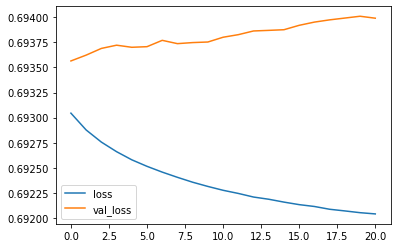

In [50]:
oPredictiveModel = Long_Short_Term_Memory(
    sSubModelName, 
    dfScaledInputTrain.shape[1], 
    1,
    len(g_aBackwardTimeSteps), 
    1
    )

oPredictiveModel.Train(dfBalancedInputTrain, 
                       dfBalancedOutputTrain,
                       dfScaledInputValidation,
                       dfOutputValidation
                      )

## Test

In [51]:
aPredictionProb, _ = oPredictiveModel.aPredict(dfScaledInputTest)

aPrediction = aPredictionProb.round()

dfPrediction = pd.DataFrame(aPrediction, index = dfInputTest.index)
dfPrediction.columns = aColumns

In [52]:
dfPrediction.value_counts()

(1, 3)
0.0       6847
1.0       2811
dtype: int64

In [53]:
print(classification_report(dfOutputTest, dfPrediction))

              precision    recall  f1-score   support

         0.0       0.52      0.72      0.60      4946
         1.0       0.50      0.30      0.37      4712

    accuracy                           0.51      9658
   macro avg       0.51      0.51      0.49      9658
weighted avg       0.51      0.51      0.49      9658



# UPWARD REGRESSION MODEL

In [54]:
sModelName = os.path.join(sSymbol , "__upward regression model__")

In [55]:
sSubModelName = os.path.join(sModelName , "__"+ str(i) +"  " + str(j) + "__")

## Preprocessing

In [211]:
dfInputUpward = dfInput.copy()
dfOutputUpward = dfOutput.copy()

In [212]:
dfOutputUpward.loc[dfMaskInvestable & dfMaskUpward, i] = dfReturn.loc[dfOutputUpward.index].loc[dfMaskInvestable & dfMaskUpward].values

In [213]:
dfOutputUpward

From,1
To,3
time,
2013-01-04 08:00:00,0.001507
2013-01-04 09:00:00,0.00104
2013-01-04 10:00:00,0.001727
2013-01-04 11:00:00,0.001141
2013-01-04 12:00:00,NaN
...,...
2021-10-27 20:00:00,0.00133
2021-10-27 21:00:00,0.001442


### Remove Empty Rows

In [214]:
aMissingOutputs = dfOutputUpward[dfOutputUpward.isna().any(axis=1)].index
dfInputUpward.drop(aMissingOutputs, inplace = True)
dfOutputUpward.drop(aMissingOutputs, inplace = True)

In [215]:
dfOutputUpward

From,1
To,3
time,
2013-01-04 08:00:00,0.001507
2013-01-04 09:00:00,0.00104
2013-01-04 10:00:00,0.001727
2013-01-04 11:00:00,0.001141
2013-01-04 16:00:00,0.000792
...,...
2021-10-27 12:00:00,0.001031
2021-10-27 18:00:00,0.000511


In [216]:
# f95thPercentile = dfOutputUpward.iloc[:,0].quantile(0.80)

# oScaler = MinMaxScaler()
# oScaler.fit(dfOutputUpward[dfOutputUpward.iloc[:,0] <= f95thPercentile])
dfOutputUpward.iloc[:,0] = np.log(dfOutputUpward.iloc[:,0].astype("float"))


### Split Data

In [217]:
dfInputTrain, dfInputValidation, dfInputTest, dfOutputTrain, dfOutputValidation, dfOutputTest = dfSplitData(dfInputUpward, 
                                                                                                            dfOutputUpward)

### Scale Data

In [218]:
dfScaledInputTrain, dfScaledInputValidation, dfScaledInputTest = dfScaleData("input", dfInputTrain,dfInputValidation, dfInputTest)

In [219]:
dfScaledOutputTrain, dfScaledOutputValidation, dfScaledOutputTest = dfScaleData("output", dfOutputTrain,dfOutputValidation, dfOutputTest)

## Train

In [223]:
iNumberOfHiddenNeuron = 100
iBatchSize = 216
oOptimizer = tf.keras.optimizers.Adam(learning_rate= 1e-06, beta_1=0.9)
oLossFunction = tf.keras.losses.MeanSquaredError()
oEarlyStop = EarlyStopping(
    monitor = 'val_loss', 
    mode = 'min', 
    verbose = 0 , 
    patience = 100, 
    restore_best_weights = True)
iEpochSize = 10000

In [224]:
oPredictiveModel = Sequential()
oPredictiveModel.add(Dense((iNumberOfHiddenNeuron)))
oPredictiveModel.add(Dense((iNumberOfHiddenNeuron)))
oPredictiveModel.add(Dense((1),activation = "sigmoid") )

oPredictiveModel.compile(optimizer=oOptimizer, loss=oLossFunction)

Epoch 1/10000
68/68 [==============================] - 1s 4ms/step - loss: 0.0651 - val_loss: 0.0763
Epoch 2/10000
68/68 [==============================] - 0s 3ms/step - loss: 0.0626 - val_loss: 0.0733
Epoch 3/10000
68/68 [==============================] - 0s 3ms/step - loss: 0.0601 - val_loss: 0.0703
Epoch 4/10000
68/68 [==============================] - 0s 3ms/step - loss: 0.0577 - val_loss: 0.0674
Epoch 5/10000
68/68 [==============================] - 0s 3ms/step - loss: 0.0553 - val_loss: 0.0645
Epoch 6/10000
68/68 [==============================] - 0s 3ms/step - loss: 0.0530 - val_loss: 0.0617
Epoch 7/10000
68/68 [==============================] - 0s 3ms/step - loss: 0.0508 - val_loss: 0.0590
Epoch 8/10000
68/68 [==============================] - 0s 3ms/step - loss: 0.0487 - val_loss: 0.0564
Epoch 9/10000
68/68 [==============================] - 0s 3ms/step - loss: 0.0466 - val_loss: 0.0538
Epoch 10/10000
68/68 [==============================] - 0s 3ms/step - loss: 0.0446 - val_lo

68/68 [==============================] - 0s 3ms/step - loss: 0.0139 - val_loss: 0.0138
Epoch 82/10000
68/68 [==============================] - 0s 3ms/step - loss: 0.0139 - val_loss: 0.0138
Epoch 83/10000
68/68 [==============================] - 0s 3ms/step - loss: 0.0139 - val_loss: 0.0138
Epoch 84/10000
68/68 [==============================] - 0s 3ms/step - loss: 0.0139 - val_loss: 0.0138
Epoch 85/10000
68/68 [==============================] - 0s 3ms/step - loss: 0.0139 - val_loss: 0.0139
Epoch 86/10000
68/68 [==============================] - 0s 3ms/step - loss: 0.0139 - val_loss: 0.0139
Epoch 87/10000
68/68 [==============================] - 0s 3ms/step - loss: 0.0139 - val_loss: 0.0139
Epoch 88/10000
68/68 [==============================] - 0s 3ms/step - loss: 0.0139 - val_loss: 0.0139
Epoch 89/10000
68/68 [==============================] - 0s 3ms/step - loss: 0.0138 - val_loss: 0.0139
Epoch 90/10000
68/68 [==============================] - 0s 3ms/step - loss: 0.0138 - val_loss: 0.

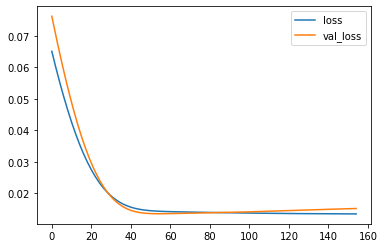

In [225]:
oPredictiveModel.fit(
    dfScaledInputTrain, 
    dfScaledOutputTrain, 
    epochs=iEpochSize, 
    batch_size=iBatchSize, 
    verbose=1, 
    validation_data= (dfScaledInputValidation, dfScaledOutputValidation), 
    callbacks=[oEarlyStop] )

oPredictiveModel.save_weights(sSubModelName)

pd.DataFrame(oPredictiveModel.history.history).plot()

## Test

In [226]:
oPredictiveModel.load_weights(sSubModelName)

aPrediction = oPredictiveModel.predict(dfScaledInputTest)

sOutputScalerPath = os.path.join(sSubModelName , "__scalers__")
sOutputScalerPath = os.path.join(sOutputScalerPath , "output" + ".sav")
oScalerOutput = pickle.load(open(sOutputScalerPath, 'rb'))
aPrediction = oScalerOutput.inverse_transform(aPrediction)

dfPrediction = pd.DataFrame(aPrediction, index = dfScaledInputTest.index)
dfPrediction.columns = aColumns

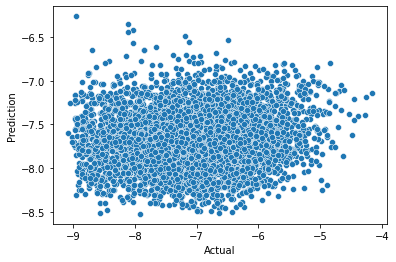

In [231]:
dfTestComparision = dfPrediction.join(dfOutputTest, how = "inner", lsuffix="prediction")
dfTestComparision.columns = ["Prediction", "Actual"]

sns.scatterplot(data = dfTestComparision, x = "Actual", y ="Prediction") 

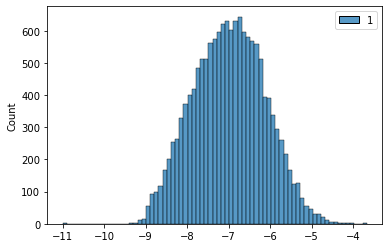

In [234]:
sns.histplot(dfOutputTrain)

In [232]:
aMetrics = [
        ('mean absolute error', mean_absolute_error(dfOutputTest, dfPrediction)),
        ('median absolute error', median_absolute_error(dfOutputTest, dfPrediction)),
        ('mean squared error', mean_squared_error(dfOutputTest, dfPrediction)),
        ('max error', max_error(dfOutputTest, dfPrediction)),
        ('r2 score', r2_score(dfOutputTest, dfPrediction)),
        ('explained variance score', explained_variance_score(dfOutputTest, dfPrediction))
    ]

print('Metrics for regression:')
for metric_name, metric_value in aMetrics:
    print(f'{metric_name:>25s}: {metric_value: >20.3f}')

Metrics for regression:
      mean absolute error:                0.926
    median absolute error:                0.845
       mean squared error:                1.249
                max error:                3.303
                 r2 score:               -0.566
 explained variance score:               -0.063


# DOWNWARD REGRESSION MODEL